# PLN Project 2 - Classic ML Models for Text Classification

This notebook implements Meta 2 of the project, following a two-phase plan:

**Phase 1: Best Feature Extraction Method**
1.  **Goal:** Find the best feature representation for the HateBR dataset.
2.  **Control Model:** `LogisticRegression` (as the fixed baseline).
3.  **Methods Tested (x4):** `CountVectorizer`, `TfidfVectorizer`, `Word2Vec` (Average), `Doc2Vec`.
4.  **Preprocessing (x2):** Test all methods with and without lemmatization.
5.  **Robustness:** Run each of the 8 combinations `N_RUNS` times and average the results (F1, Precision, Recall).

**Phase 2: Model Optimization with Optuna**
1.  **Goal:** Find the best hyperparameters for the top classic models.
2.  **Representation:** Use the *single best* representation identified in Phase 1.
3.  **Models Tested (x3):** `LogisticRegression`, `LinearSVC` (Linear Kernel SVM), `MultinomialNB`.
4.  **Framework:** `Optuna` is used for hyperparameter tuning.

**Phase 3: Final Evaluation**
1.  **Goal:** Report the performance of the single best model.
2.  **Method:** The best estimator found by Optuna is trained on the full training set and evaluated on the held-out test set.

## Part 0: Setup, Imports and Preprocessing Functions

In [ ]:
# --- General Imports ---
import pandas as pd
import numpy as np
import re
import string
import time
import warnings
from collections import defaultdict
from tqdm.notebook import tqdm

# --- NLTK and Spacy (for preprocessing) ---
import spacy
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
stopwords_pt = nltk.corpus.stopwords.words("portuguese")

# --- Scikit-learn (for classic ML) ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# --- Gensim (for Word2Vec/Doc2Vec) ---
import gensim.models
from gensim.models.doc2vec import TaggedDocument

# --- Optuna (for HPO) ---
import optuna

# --- Setup Environment ---
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_colwidth', 200)

try:
    nlp = spacy.load("pt_core_news_sm")
except IOError:
    print("Spacy model 'pt_core_news_sm' not found. Please run:")
    print("python -m spacy download pt_core_news_sm")
    nlp = None

# Emoji pattern
emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                            "]", flags=re.UNICODE)

def separate_emojis(text):
    return emoji_pattern.sub(r' \g<0> ', text)

### Preprocessing Functions

In [2]:
def preprocess_to_tokens(text, lemmatize=False):
    """Processes raw text into a list of clean tokens."""
    if nlp is None and lemmatize:
        raise IOError("Spacy 'pt_core_news_sm' model not loaded. Cannot lemmatize.")

    text = str(text).lower()
    text = separate_emojis(text)

    if lemmatize:
        doc = nlp(text)
        tokens = [token.lemma_ if not emoji_pattern.fullmatch(token.text) else token.text
                for token in doc]
    else:
        tokens = word_tokenize(text)

    tokens = [t for t in tokens if t.strip() != "" and t not in {"️", "\u200d"}]

    filtered_tokens = []
    for token in tokens:
        # Remove punctuation
        if token in string.punctuation:
            continue
        token = re.sub(r"\.\*", "", token) # Remove artifacts
        parts = re.split(f"[{re.escape(string.punctuation)}]", token) # Split on punctuation (e.g., "doente.pilantra")
        filtered_tokens.extend([p.lower() for p in parts if p])

    # Remove stopwords but keep emojis
    final_tokens = [token for token in filtered_tokens if token not in stopwords_pt or emoji_pattern.fullmatch(token)]

    return final_tokens

def preprocess_to_string(text, lemmatize=False):
    """Processes raw text into a single string of clean tokens for vectorizers."""
    tokens = preprocess_to_tokens(text, lemmatize=lemmatize)
    return " ".join(tokens)

### Load Data

In [3]:
# Loading dataset
url = "https://raw.githubusercontent.com/franciellevargas/HateBR/refs/heads/main/dataset/HateBR.csv"
df = pd.read_csv(url)

X = df['comentario']
y = df['label_final']

print(df.columns)
df

Index(['id', 'comentario', 'anotator1', 'anotator2', 'anotator3',
       'label_final', 'links_post', 'account_post'],
      dtype='object')


,id,comentario,anotator1,anotator2,anotator3,label_final,links_post,account_post
0,1,Mais um lixo,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
1,2,Essa nao tem vergonha na cara!!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
2,3,Essa mulher é doente.pilantra!,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
3,4,Comunista safada...,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
4,5,Vagabunda. Comunista. Mentirosa. O povo chileno nao merece uma desgraça desta.,1,1,1,1,https://www.instagram.com/p/B2uThqdH9xI/,Carla Zambelli
...,...,...,...,...,...,...,...,...
6995,6996,Parabéns Eduardo!!! Deus te proteja. Obrigada por tudo 🙏🇧🇷💚💛,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6996,6997,A melhor maneira de unir a direita do mundo todo!!,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6997,6998,Vcs são lutadores. Sejam protegidos.,0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro
6998,6999,"Parabéns Deus abençoe 🙌, que a verdade traga a justiça.",0,0,0,0,https://www.instagram.com/p/C5rDlbTPTJq/,Eduardo Bolsonaro


## Part 1: Best Feature Extraction Method

We will run `N_RUNS` experiments. In each run, we split the data differently and train all 8 combinations.
This gives us a robust average score for each method.

**Control Model:** `LogisticRegression(solver='liblinear')`

**Combinations (2x4=8):**
1.  `CountVectorizer` (No Lemma)
2.  `CountVectorizer` (With Lemma)
3.  `TfidfVectorizer` (No Lemma)
4.  `TfidfVectorizer` (With Lemma)
5.  `Word2Vec (Average)` (No Lemma)
6.  `Word2Vec (Average)` (With Lemma)
7.  `Doc2Vec` (No Lemma)
8.  `Doc2Vec` (With Lemma)

In [4]:
N_RUNS = 5  # Number of iterations for robust scoring
W2V_DIM = 100 # Dimensionality for Word2Vec/Doc2Vec

# Use defaultdict for easy score appending
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

def get_metrics(y_true, y_pred):
    """Calculates F1, Precision, and Recall (weighted)."""
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    return f1, precision, recall

def document_vector_avg(tokens, model, num_features):
    """Creates an average vector for a document from a Word2Vec model."""
    feature_vec = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in tokens:
        if word in model.wv:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

for run in tqdm(range(N_RUNS), desc="Total Runs"):
    
    # Split data differently for each run for robustness and reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=run, stratify=y)
    
    # Baseline Model
    control_model_lr = LogisticRegression(solver='liblinear', random_state=run, max_iter=1000)

    # Iterate over lemmatization options
    for lemmatize_enabled in [False, True]:
        lem_key = "Lemma_True" if lemmatize_enabled else "Lemma_False"
        print(f"\n--- Run {run+1}/{N_RUNS} | {lem_key} ---")

        # --- A. Pre-process all data for this setting ---
        print(f"Preprocessing text...")
        # For CountVect/TF-IDF (returns string)
        # We use a wrapper that will be called by the pipeline's preprocessor
        preprocessor_str_func = lambda text: preprocess_to_string(text, lemmatize=lemmatize_enabled)
        
        # For W2V/D2V (returns list of tokens)
        X_train_tok = [preprocess_to_tokens(text, lemmatize=lemmatize_enabled) for text in tqdm(X_train, desc="Tokenizing Train Data")]
        X_test_tok = [preprocess_to_tokens(text, lemmatize=lemmatize_enabled) for text in X_test]
        
        # --- B. Test Sparse Vectors: CountVectorizer & TF-IDF ---
        for vect_name, vectorizer in [('CountVectorizer', CountVectorizer(preprocessor=preprocessor_str_func)),
                                    ('TfidfVectorizer', TfidfVectorizer(preprocessor=preprocessor_str_func))]:
            print(f"Testing {vect_name}...")
            try:
                # Create and train the pipeline
                pipeline_lr = Pipeline([
                    ('vect', vectorizer),
                    ('clf', control_model_lr)
                ])
                start_time = time.time()
                pipeline_lr.fit(X_train, y_train) # Pass raw X_train, preprocessor is in the vectorizer
                y_pred = pipeline_lr.predict(X_test)
                print(f"...done in {time.time() - start_time:.2f}s")
                
                # Store scores
                f1, p, r = get_metrics(y_test, y_pred)
                results[vect_name][lem_key]['f1'].append(f1)
                results[vect_name][lem_key]['precision'].append(p)
                results[vect_name][lem_key]['recall'].append(r)
            except Exception as e:
                print(f"Failed {vect_name} with LR: {e}")

        # --- C. Test Dense Vectors: Word2Vec (Average) ---
        print("Testing Word2Vec (Average)...")
        try:
            start_time = time.time()
            # 1. Train W2V model on training tokens
            w2v_model = gensim.models.Word2Vec(X_train_tok, vector_size=W2V_DIM, window=5, min_count=2, workers=4, epochs=10)
            
            # 2. Transform tokens to vectors
            X_train_w2v = np.array([document_vector_avg(tokens, w2v_model, W2V_DIM) for tokens in X_train_tok])
            X_test_w2v = np.array([document_vector_avg(tokens, w2v_model, W2V_DIM) for tokens in X_test_tok])
            
            # 3. Train and eval Logistic Regression
            control_model_lr.fit(X_train_w2v, y_train)
            y_pred_lr = control_model_lr.predict(X_test_w2v)
            print(f"...done in {time.time() - start_time:.2f}s")
            
            f1, p, r = get_metrics(y_test, y_pred_lr)
            results['Word2Vec'][lem_key]['f1'].append(f1)
            results['Word2Vec'][lem_key]['precision'].append(p)
            results['Word2Vec'][lem_key]['recall'].append(r)
            
        except Exception as e:
            print(f"Failed Word2Vec: {e}")

        # --- D. Test Dense Vectors: Doc2Vec ---
        print("Testing Doc2Vec...")
        try:
            start_time = time.time()
            # 1. Tag documents
            tagged_train_data = [TaggedDocument(words=tokens, tags=[i]) for i, tokens in enumerate(X_train_tok)]
            
            # 2. Train D2V model
            d2v_model = gensim.models.Doc2Vec(vector_size=W2V_DIM, window=5, min_count=2, workers=4, epochs=40, dm=1)
            d2v_model.build_vocab(tagged_train_data)
            d2v_model.train(tagged_train_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
            
            # 3. Infer vectors
            X_train_d2v = np.array([d2v_model.infer_vector(tokens) for tokens in X_train_tok])
            X_test_d2v = np.array([d2v_model.infer_vector(tokens) for tokens in X_test_tok])
            
            # 4. Train and eval Logistic Regression
            control_model_lr.fit(X_train_d2v, y_train)
            y_pred_lr = control_model_lr.predict(X_test_d2v)
            print(f"...done in {time.time() - start_time:.2f}s")
            
            f1, p, r = get_metrics(y_test, y_pred_lr)
            results['Doc2Vec'][lem_key]['f1'].append(f1)
            results['Doc2Vec'][lem_key]['precision'].append(p)
            results['Doc2Vec'][lem_key]['recall'].append(r)
            
        except Exception as e:
            print(f"Failed Doc2Vec: {e}")

print("\n--- Phase 1 Complete ---")

Total Runs:   0%|          | 0/5 [00:00<?, ?it/s]


--- Run 1/5 | Lemma_False ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 2.57s
Testing TfidfVectorizer...
...done in 2.42s
Testing Word2Vec (Average)...
...done in 0.90s
Testing Doc2Vec...
...done in 25.67s

--- Run 1/5 | Lemma_True ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 99.46s
Testing TfidfVectorizer...
...done in 97.05s
Testing Word2Vec (Average)...
...done in 0.84s
Testing Doc2Vec...
...done in 31.67s

--- Run 2/5 | Lemma_False ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 3.45s
Testing TfidfVectorizer...
...done in 3.33s
Testing Word2Vec (Average)...
...done in 1.09s
Testing Doc2Vec...
...done in 40.67s

--- Run 2/5 | Lemma_True ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 115.32s
Testing TfidfVectorizer...
...done in 114.63s
Testing Word2Vec (Average)...
...done in 1.13s
Testing Doc2Vec...
...done in 40.97s

--- Run 3/5 | Lemma_False ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 3.54s
Testing TfidfVectorizer...
...done in 3.37s
Testing Word2Vec (Average)...
...done in 1.10s
Testing Doc2Vec...
...done in 40.50s

--- Run 3/5 | Lemma_True ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 87.55s
Testing TfidfVectorizer...
...done in 88.30s
Testing Word2Vec (Average)...
...done in 0.86s
Testing Doc2Vec...
...done in 25.79s

--- Run 4/5 | Lemma_False ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 2.31s
Testing TfidfVectorizer...
...done in 2.53s
Testing Word2Vec (Average)...
...done in 0.84s
Testing Doc2Vec...
...done in 26.03s

--- Run 4/5 | Lemma_True ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 84.48s
Testing TfidfVectorizer...
...done in 91.92s
Testing Word2Vec (Average)...
...done in 1.10s
Testing Doc2Vec...
...done in 41.10s

--- Run 5/5 | Lemma_False ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 2.41s
Testing TfidfVectorizer...
...done in 2.26s
Testing Word2Vec (Average)...
...done in 0.77s
Testing Doc2Vec...
...done in 31.49s

--- Run 5/5 | Lemma_True ---
Preprocessing text...


Tokenizing Train Data:   0%|          | 0/5600 [00:00<?, ?it/s]

Testing CountVectorizer...
...done in 87.98s
Testing TfidfVectorizer...
...done in 89.29s
Testing Word2Vec (Average)...
...done in 0.89s
Testing Doc2Vec...
...done in 28.65s

--- Phase 1 Complete ---


### Phase 1 Results

In [5]:
summary_results = []

for vect_name, lem_dict in results.items():
    for lem_key, metrics_dict in lem_dict.items():
        # We use F1 as the primary comparison metric
        f1_scores = metrics_dict.get('f1', [])
        if not f1_scores:
            # Fallback if key is 'f1_lr' etc.
            f1_scores = metrics_dict.get('f1_lr', [])
        
        if f1_scores:
            mean_f1 = np.mean(f1_scores)
            std_f1 = np.std(f1_scores)
            mean_p = np.mean(metrics_dict.get('precision', metrics_dict.get('precision_lr', [])))
            mean_r = np.mean(metrics_dict.get('recall', metrics_dict.get('recall_lr', [])))
            
            summary_results.append({
                'Vectorizer': vect_name,
                'Lemmatization': lem_key,
                'Mean F1': mean_f1,
                'Std F1': std_f1,
                'Mean Precision': mean_p,
                'Mean Recall': mean_r
            })

# Create a DataFrame for easy viewing
results_df = pd.DataFrame(summary_results)
results_df = results_df.sort_values(by='Mean F1', ascending=False)

print("--- Feature Extraction Phase 1 Results (Ranked by Mean F1) ---")
print(results_df.to_markdown(index=False, floatfmt=".4f"))

# Get the winning combination
best_combination = results_df.iloc[0]
print("\n--- Best Combination ---_\n")
print(best_combination)

--- Feature Extraction Phase 1 Results (Ranked by Mean F1) ---
| Vectorizer      | Lemmatization   |   Mean F1 |   Std F1 |   Mean Precision |   Mean Recall |
|:----------------|:----------------|----------:|---------:|-----------------:|--------------:|
| CountVectorizer | Lemma_True      |    0.8415 |   0.0117 |           0.8447 |        0.8419 |
| TfidfVectorizer | Lemma_True      |    0.8344 |   0.0111 |           0.8347 |        0.8344 |
| CountVectorizer | Lemma_False     |    0.8340 |   0.0106 |           0.8382 |        0.8344 |
| TfidfVectorizer | Lemma_False     |    0.8288 |   0.0059 |           0.8293 |        0.8289 |
| Doc2Vec         | Lemma_True      |    0.7689 |   0.0067 |           0.7696 |        0.7690 |
| Doc2Vec         | Lemma_False     |    0.7594 |   0.0058 |           0.7597 |        0.7594 |
| Word2Vec        | Lemma_True      |    0.7309 |   0.0100 |           0.7417 |        0.7333 |
| Word2Vec        | Lemma_False     |    0.7293 |   0.0107 |           0.

## Part 2: Model Optimization (Optuna)

Now, we take the winning combination from Part 1 and use it as the fixed representation for tuning our three classifiers: `LogisticRegression`, `LinearSVC`, and `MultinomialNB`.

In [ ]:
# --- !!! SET THESE VARIABLES BASED ON PHASE 1 RESULTS !!! ---
# The code automatically picks the winner from the DataFrame above.
# You can also override them manually, e.g.:
# best_vect_name = 'TfidfVectorizer'
# BEST_LEMMATIZATION = False
# --------------------------------------------------------------------

# We get the winner from the 'results_df' DataFrame
best_vect_name = best_combination['Vectorizer']
BEST_LEMMATIZATION = best_combination['Lemmatization'] == 'Lemma_True'

if best_vect_name == 'CountVectorizer':
    BEST_VECTORIZER_CLASS = CountVectorizer
    BEST_VECTORIZER_TYPE = 'sparse'
elif best_vect_name == 'TfidfVectorizer':
    BEST_VECTORIZER_CLASS = TfidfVectorizer
    BEST_VECTORIZER_TYPE = 'sparse'
elif best_vect_name == 'Word2Vec':
    BEST_VECTORIZER_CLASS = 'w2v' # Special case flag
    BEST_VECTORIZER_TYPE = 'dense'
else: # Doc2Vec
    BEST_VECTORIZER_CLASS = 'd2v' # Special case flag
    BEST_VECTORIZER_TYPE = 'dense'


print(f"--- Starting Phase 2 with ---")
print(f"Vectorizer: {best_vect_name}")
print(f"Lemmatization: {BEST_LEMMATIZATION}")
print(f"Vector Type: {BEST_VECTORIZER_TYPE}")

# Prepare the final, full training and test sets for Optuna
print("\nPreparing full dataset for optimization...")
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# These variables will be used by the Optuna objectives
X_opt_train = None
y_opt_train = y_train_full

# Create the preprocessor function based on the winner
preprocessor_func = lambda text: preprocess_to_string(text, lemmatize=BEST_LEMMATIZATION)

if BEST_VECTORIZER_TYPE == 'sparse':
    # For sparse models, we pass the PRE-PROCESSED text
    print("Preprocessing full training set for Optuna...")
    X_opt_train = [preprocessor_func(text) for text in tqdm(X_train_full, desc="Preprocessing Optuna Train")]
    print("Preprocessing complete.")

print("\nData preparation complete.")

--- Starting Phase 2 with ---
Vectorizer: CountVectorizer
Lemmatization: True
Vector Type: sparse

Preparing full dataset for optimization...
Preprocessing full training set for Optuna...


Preprocessing Optuna Train:   0%|          | 0/5600 [00:00<?, ?it/s]

Preprocessing complete.

Data preparation complete.


### Optuna Objective Functions

**Note:** If `BEST_VECTORIZER_TYPE` is 'dense', `MultinomialNB` cannot be used and will be replaced by `GaussianNB`.

In [7]:
from sklearn.model_selection import cross_validate
N_OPTUNA_TRIALS = 50 # Number of trials for each model
CV_FOLDS = 10 # Number of cross-validation folds

# --- Define the metrics we want to track ---
scoring_metrics = {
    'f1': 'f1_weighted',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted'
}

# --- Objective 1: Logistic Regression ---
def objective_lr(trial):
    
    if BEST_VECTORIZER_TYPE == 'sparse':
        vect_params = {
            'ngram_range': trial.suggest_categorical('vect__ngram_range', [(1, 1), (1, 2)]),
            'min_df': trial.suggest_int('vect__min_df', 1, 5),
            'max_df': trial.suggest_float('vect__max_df', 0.5, 1.0)
        }
        solver = trial.suggest_categorical('clf__solver', ['liblinear', 'saga'])
        penalty = trial.suggest_categorical('clf__penalty', ['l1', 'l2'])
        
        if solver == 'liblinear' and penalty == 'l1':
            clf_params = {'solver': solver, 'penalty': penalty}
        elif solver == 'saga' and penalty == 'l1':
            clf_params = {'solver': solver, 'penalty': penalty}
        else:
            clf_params = {'solver': solver, 'penalty': 'l2'}
            
        clf_params['C'] = trial.suggest_float('clf__C', 1e-2, 1e2, log=True)
            
        pipeline = Pipeline([
            ('vect', BEST_VECTORIZER_CLASS(preprocessor=None, **vect_params)),
            ('clf', LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced', **clf_params))
        ])
        X_data = X_opt_train
    
    # Use cross_validate to get all scores
    scores = cross_validate(pipeline, X_data, y_opt_train, n_jobs=-1, cv=CV_FOLDS, scoring=scoring_metrics)
    
    # Calculate means
    mean_f1 = np.mean(scores['test_f1'])
    mean_precision = np.mean(scores['test_precision'])
    mean_recall = np.mean(scores['test_recall'])
    
    # Store the other metrics as user attributes
    trial.set_user_attr("mean_precision", mean_precision)
    trial.set_user_attr("mean_recall", mean_recall)
    
    # Return the primary metric for optimization
    return mean_f1

# --- Objective 2: Linear SVM (LinearSVC) ---
def objective_svc(trial):
    
    if BEST_VECTORIZER_TYPE == 'sparse':
        vect_params = {
            'ngram_range': trial.suggest_categorical('vect__ngram_range', [(1, 1), (1, 2)]),
            'min_df': trial.suggest_int('vect__min_df', 1, 5),
            'max_df': trial.suggest_float('vect__max_df', 0.5, 1.0)
        }
        clf_params = {
            'C': trial.suggest_float('clf__C', 1e-3, 1e3, log=True),
        }
        
        pipeline = Pipeline([
            ('vect', BEST_VECTORIZER_CLASS(preprocessor=None, **vect_params)),
            ('clf', LinearSVC(random_state=42, max_iter=3000, class_weight='balanced', dual='auto', **clf_params))
        ])
        X_data = X_opt_train
    
    scores = cross_validate(pipeline, X_data, y_opt_train, n_jobs=-1, cv=CV_FOLDS, scoring=scoring_metrics)
    mean_f1 = np.mean(scores['test_f1'])
    mean_precision = np.mean(scores['test_precision'])
    mean_recall = np.mean(scores['test_recall'])
    trial.set_user_attr("mean_precision", mean_precision)
    trial.set_user_attr("mean_recall", mean_recall)
    return mean_f1

# --- Objective 3: Naive Bayes ---
def objective_nb(trial):
    
    if BEST_VECTORIZER_TYPE == 'sparse':
        vect_params = {
            'ngram_range': trial.suggest_categorical('vect__ngram_range', [(1, 1), (1, 2)]),
            'min_df': trial.suggest_int('vect__min_df', 1, 5),
            'max_df': trial.suggest_float('vect__max_df', 0.5, 1.0)
        }
        clf_params = {
            'alpha': trial.suggest_float('clf__alpha', 1e-2, 1.0, log=True),
        }
        pipeline = Pipeline([
            ('vect', BEST_VECTORIZER_CLASS(preprocessor=None, **vect_params)),
            ('clf', MultinomialNB(**clf_params))
        ])
        X_data = X_opt_train
    
    scores = cross_validate(pipeline, X_data, y_opt_train, n_jobs=-1, cv=CV_FOLDS, scoring=scoring_metrics)
    mean_f1 = np.mean(scores['test_f1'])
    mean_precision = np.mean(scores['test_precision'])
    mean_recall = np.mean(scores['test_recall'])
    trial.set_user_attr("mean_precision", mean_precision)
    trial.set_user_attr("mean_recall", mean_recall)
    return mean_f1

### Run Optuna Studies

This will run `N_OPTUNA_TRIALS` for each of the 3 models.

In [8]:
print("--- Starting Optuna: Logistic Regression ---")
study_lr = optuna.create_study(direction="maximize", study_name="LogisticRegression")
study_lr.optimize(objective_lr, n_trials=N_OPTUNA_TRIALS)

# Get metrics from the best trial
best_f1_lr = study_lr.best_value
best_precision_lr = study_lr.best_trial.user_attrs.get('mean_precision', 0.0)
best_recall_lr = study_lr.best_trial.user_attrs.get('mean_recall', 0.0)

print(f"Best F1 (LR): {best_f1_lr:.4f}")
print(f"Best Precision (LR): {best_precision_lr:.4f}")
print(f"Best Recall (LR): {best_recall_lr:.4f}")
print(f"Best Params (LR): {study_lr.best_params}")

--- Starting Optuna: Logistic Regression ---
Best F1 (LR): 0.8452
Best Precision (LR): 0.8488
Best Recall (LR): 0.8455
Best Params (LR): {'vect__ngram_range': (1, 1), 'vect__min_df': 1, 'vect__max_df': 0.7980908810289892, 'clf__solver': 'saga', 'clf__penalty': 'l2', 'clf__C': 10.663142276044136}


In [10]:
print("\n--- Starting Optuna: Linear SVM (LinearSVC) ---")
study_svc = optuna.create_study(direction="maximize", study_name="LinearSVC")
study_svc.optimize(objective_svc, n_trials=N_OPTUNA_TRIALS)

# Get metrics from the best trial
best_f1_svc = study_svc.best_value
best_precision_svc = study_svc.best_trial.user_attrs.get('mean_precision', 0.0)
best_recall_svc = study_svc.best_trial.user_attrs.get('mean_recall', 0.0)

print(f"Best F1 (SVC): {best_f1_svc:.4f}")
print(f"Best Precision (SVC): {best_precision_svc:.4f}")
print(f"Best Recall (SVC): {best_recall_svc:.4f}")
print(f"Best Params (SVC): {study_svc.best_params}")


--- Starting Optuna: Linear SVM (LinearSVC) ---
Best F1 (SVC): 0.8447
Best Precision (SVC): 0.8494
Best Recall (SVC): 0.8452
Best Params (SVC): {'vect__ngram_range': (1, 1), 'vect__min_df': 1, 'vect__max_df': 0.8858961492775645, 'clf__C': 0.3240578544555904}


In [11]:
print("\n--- Starting Optuna: Naive Bayes ---")
study_nb = optuna.create_study(direction="maximize", study_name="NaiveBayes")
study_nb.optimize(objective_nb, n_trials=N_OPTUNA_TRIALS)

# Get metrics from the best trial
best_f1_nb = study_nb.best_value
best_precision_nb = study_nb.best_trial.user_attrs.get('mean_precision', 0.0)
best_recall_nb = study_nb.best_trial.user_attrs.get('mean_recall', 0.0)

print(f"Best F1 (NB): {best_f1_nb:.4f}")
print(f"Best Precision (NB): {best_precision_nb:.4f}")
print(f"Best Recall (NB): {best_recall_nb:.4f}")
print(f"Best Params (NB): {study_nb.best_params}")


--- Starting Optuna: Naive Bayes ---
Best F1 (NB): 0.8391
Best Precision (NB): 0.8423
Best Recall (NB): 0.8395
Best Params (NB): {'vect__ngram_range': (1, 1), 'vect__min_df': 1, 'vect__max_df': 0.9861175047992199, 'clf__alpha': 0.45685531324161627}


## Part 3: Final Evaluation

We now find the overall best model from the three Optuna studies and run it on the final hold-out test set (`X_test_final`, `y_test_final`) to get our reportable score.

--- Overall Winner: LogisticRegression ---
Best cross-val F1: 0.8452
Best cross-val Precision: 0.8488
Best cross-val Recall: 0.8455
Best Hyperparameters: {'vect__ngram_range': (1, 1), 'vect__min_df': 1, 'vect__max_df': 0.7980908810289892, 'clf__solver': 'saga', 'clf__penalty': 'l2', 'clf__C': 10.663142276044136}

Building final model with best parameters...
Training final pipeline on full training data...
Preprocessing final test set...


Preprocessing Test Set:   0%|          | 0/1400 [00:00<?, ?it/s]

Evaluating on final test set...

--- FINAL CLASSIFICATION REPORT ---
Model: LogisticRegression
Vectorizer: CountVectorizer
Lemmatization: True


                   precision    recall  f1-score   support

Not Offensive (0)       0.83      0.88      0.86       700
    Offensive (1)       0.87      0.82      0.85       700

         accuracy                           0.85      1400
        macro avg       0.85      0.85      0.85      1400
     weighted avg       0.85      0.85      0.85      1400



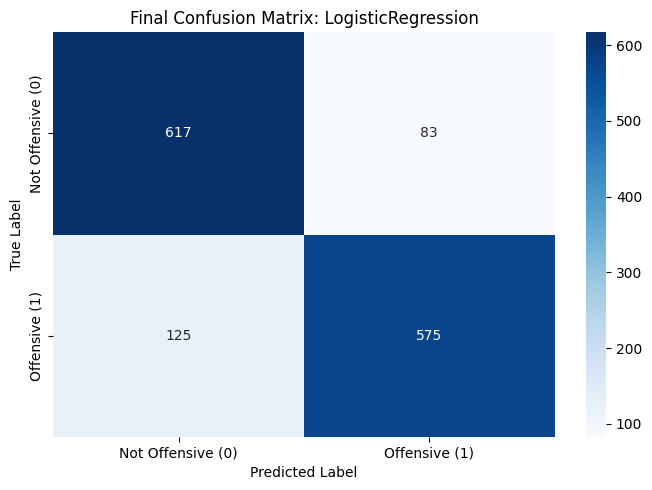

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

studies = {
    'LogisticRegression': study_lr,
    'LinearSVC': study_svc,
    'NaiveBayes': study_nb
}

# Find the best model among the three studies
best_model_name = ""
best_study = None
best_score = -1

for name, study in studies.items():
    if study.best_value > best_score:
        best_score = study.best_value
        best_model_name = name
        best_study = study

print(f"--- Overall Winner: {best_model_name} ---")
print(f"Best cross-val F1: {best_score:.4f}")

# Print all metrics for the winner
best_precision = best_study.best_trial.user_attrs.get('mean_precision', 0.0)
best_recall = best_study.best_trial.user_attrs.get('mean_recall', 0.0)
print(f"Best cross-val Precision: {best_precision:.4f}")
print(f"Best cross-val Recall: {best_recall:.4f}")

print(f"Best Hyperparameters: {best_study.best_params}")

# Re-build the final, best pipeline with the best params
print("\nBuilding final model with best parameters...")
final_pipeline = None
best_params = best_study.best_params

if BEST_VECTORIZER_TYPE == 'sparse':
    # Separate vectorizer and classifier params from Optuna's keys
    vect_params = {k.replace('vect__', ''): v for k, v in best_params.items() if k.startswith('vect__')}
    clf_params = {k.replace('clf__', ''): v for k, v in best_params.items() if k.startswith('clf__')}
    
    # Set preprocessor to None (it's already done)
    vect_params['preprocessor'] = None
    
    vectorizer = BEST_VECTORIZER_CLASS(**vect_params)
    
    classifier = None
    
    if best_model_name == 'LogisticRegression':
        classifier = LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced', **clf_params)
    elif best_model_name == 'LinearSVC':
        classifier = LinearSVC(random_state=42, max_iter=3000, class_weight='balanced', dual='auto', **clf_params)
    elif best_model_name == 'NaiveBayes':
        classifier = MultinomialNB(**clf_params)
        
    final_pipeline = Pipeline([
        ('vect', vectorizer),
        ('clf', classifier)
    ])
    
    # Train on the full training data
    print("Training final pipeline on full training data...")
    final_pipeline.fit(X_opt_train, y_opt_train)
    
    # Preprocess the final test set
    print("Preprocessing final test set...")
    X_test_final_processed = [preprocessor_func(text) for text in tqdm(X_test_final, desc="Preprocessing Test Set")]
    
    # Predict on the hold-out test set
    print("Evaluating on final test set...")
    final_predictions = final_pipeline.predict(X_test_final_processed)

# Final Report
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(f"Model: {best_model_name}")
print(f"Vectorizer: {best_vect_name}")
print(f"Lemmatization: {BEST_LEMMATIZATION}")
print("\n")
target_names = ['Not Offensive (0)', 'Offensive (1)']
print(classification_report(y_test_final, final_predictions, target_names=target_names))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test_final, final_predictions)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Final Confusion Matrix: {best_model_name}")
plt.tight_layout()
plt.show()